# Home Credit Default Risk

In [1]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

In [2]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="6df20682-3fc5-48fd-98e3-927f1ffaf36b",
    resource_group_name="antoine.naudy-rg",
    workspace_name="formation",)

In [3]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "PDS6"#"cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_DS3_V2",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=4,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )
    print(
         f"AMLCompute with name {cpu_cluster.name} will be created, with compute size {cpu_cluster.size}"
          )
    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster)

You already have a cluster named PDS6, we'll reuse it as is.


In [4]:
# Create a job environment
import os

dependencies_dir = "./dependencies"
os.makedirs(dependencies_dir, exist_ok=True)

In [5]:
%%writefile {dependencies_dir}/conda.yml
# Give the requirement for the virtual environment
name: model-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - numpy=1.21.2
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pandas>=1.1,<1.2
  - pip:
    - inference-schema[numpy-support]==1.3.0
    - xlrd==2.0.1
    - mlflow== 1.26.1
    - azureml-mlflow==1.42.0
    - psutil>=5.8,<5.9
    - tqdm>=4.59,<4.60
    - ipykernel~=6.0
    - matplotlib
    - lightgbm

Overwriting ./dependencies/conda.yml


In [6]:
# Create the virtual environment
from azure.ai.ml.entities import Environment

custom_env_name = "aml-scikit-learn"

pipeline_job_env = Environment(
    name=custom_env_name,
    description="Custom environment for Credit Card Defaults pipeline",
    tags={"scikit-learn": "0.24.2"},
    conda_file=os.path.join(dependencies_dir, "conda.yml"),
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest",
)
pipeline_job_env = ml_client.environments.create_or_update(pipeline_job_env)

print(
    f"Environment with name {pipeline_job_env.name} is registered to workspace, the environment version is {pipeline_job_env.version}"
)

Environment with name aml-scikit-learn is registered to workspace, the environment version is 53


# Part 1 : Cleaning

Cleaned dataset df was retrieved from "https://www.kaggle.com/code/brandonsfick/group-2-v01"

In [7]:
# pip install lightgbm

In [8]:
# pip install ydata_profiling

In [9]:
# Import generic libraries
import pandas as pd
import numpy as np

In [10]:
# Load dataset
df = pd.read_csv("df.csv").sample(10000)#[['DAYS_ID_PUBLISH','DAYS_BIRTH','TARGET']].sample(1000)

In [11]:
# Describe the data
#from ydata_profiling import ProfileReport
#profile = ProfileReport(df, minimal=True)
#profile.to_file("report.html")

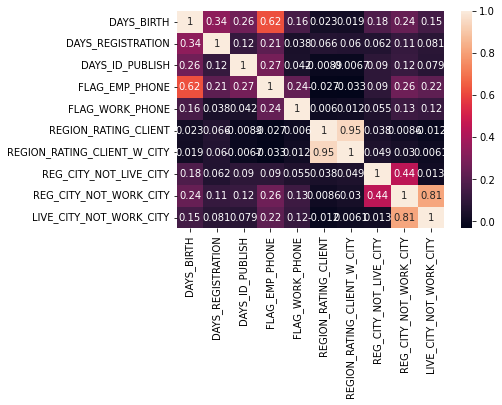

In [12]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.iloc[:,0:10].corr()

sns.heatmap(corr_matrix, annot=True)
plt.show()

In [13]:
# List of correlation pairs in descending order
corr_matrix = df.corr()
corr_series = corr_matrix.unstack()
sorted_corr = corr_series.sort_values(ascending=False)
sorted_corr = sorted_corr[sorted_corr != 1]
print(sorted_corr)


AMT_TOTAL_RECEIVABLE_MEAN         AMT_RECIVABLE_MEAN                  0.999998
AMT_RECIVABLE_MEAN                AMT_TOTAL_RECEIVABLE_MEAN           0.999998
AMT_BALANCE_MEAN                  AMT_RECIVABLE_MEAN                  0.999961
AMT_RECIVABLE_MEAN                AMT_BALANCE_MEAN                    0.999961
AMT_TOTAL_RECEIVABLE_MEAN         AMT_BALANCE_MEAN                    0.999950
                                                                        ...   
MONTHS_BALANCE_MEAN_y             SK_ID_CURR_MEAN                    -0.658671
                                  NAME_CONTRACT_STATUS_Active_MEAN   -0.695216
NAME_CONTRACT_STATUS_Active_MEAN  MONTHS_BALANCE_MEAN_y              -0.695216
MONTHS_BALANCE_MEAN_y             Date_Rank_MEAN                     -0.703882
Date_Rank_MEAN                    MONTHS_BALANCE_MEAN_y              -0.703882
Length: 6972, dtype: float64


In [14]:
# Drop highly correlated variables - threshold 90% correlation
df = df.drop(columns=['AMT_RECIVABLE_MEAN','AMT_TOTAL_RECEIVABLE_MEAN'])
df = df.drop(columns=['AMT_RECEIVABLE_PRINCIPAL_MEAN','DAYS_ENTRY_PAYMENT_MEAN','NAME_CONTRACT_STATUS_Active_MEAN'])
df=df.drop(columns=['DAYS_EMPLOYED_PERCENT','AMT_PAYMENT_CURRENT_MEAN','AMT_INST_MIN_REGULARITY_MEAN'])
df=df.drop(columns=['CNT_DRAWINGS_POS_CURRENT_MEAN','CNT_INSTALMENT_FUTURE_MEAN','DAYS_ENDDATE_FACT_SUM'])
df=df.drop(columns=['REGION_RATING_CLIENT_W_CITY','AMT_DRAWINGS_CURRENT_MEAN','DEF_60_CNT_SOCIAL_CIRCLE'])
df=df.drop(columns=['MONTHS_BALANCE_MEAN_x','Date_Rank_MEAN','DAYS_ENDDATE_FACT_MIN'])

# Part 2 : Exploratory Data Analysis

# Part 3 : Model selection

In [15]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 3-1 : Preprocessing : RobustScaler and SMOTE

## 3-1-1 RobustScaler

In [16]:
# Import libraries for preprocessing
import time

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import auc, roc_curve, accuracy_score, roc_auc_score 
from sklearn.metrics import det_curve

from sklearn.model_selection import train_test_split, GridSearchCV

In [17]:
# Normalize data and split
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X = df.drop(columns='TARGET').values
#X = scaler.fit_transform(X) _> no normalization
y = df['TARGET'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## 3-1-2 SMOTE

In [18]:
#pip install imblearn

In [19]:
# Model use for SMOTE testing
model = DecisionTreeClassifier() 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Counter({0.0: 7347, 1.0: 653})
Counter({0.0: 7347, 1.0: 7347})


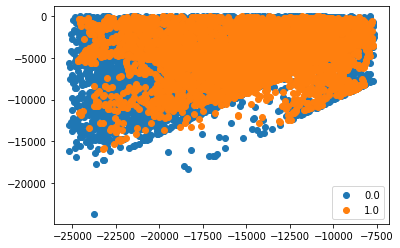

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
Train results:  
Model:  DecisionTreeClassifier() 
Best parameters:  {} 
Best ROC AUC: 0.90
Test results: 
Cost (10fn+fp): 0.70
AUC: 0.55
Accuracy: 0.85


In [20]:
# First option : borderline-SMOTE for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE
from matplotlib import pyplot
from numpy import where
from sklearn.metrics import confusion_matrix


%pylab inline
# summarize class distribution
counter = Counter(y_train)
print(counter)
# transform the dataset
oversample = BorderlineSMOTE()
X_, y_ = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y_ == label)[0]
 pyplot.scatter(X_[row_ix, 0], X_[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

# prediction
clf = GridSearchCV(model,
            param_grid={},
            cv=5,
            scoring='roc_auc',
            verbose=2)
clf.fit(X_,y_)

# Train scoring
print('Train results: ','\nModel: ', clf.best_estimator_, '\nBest parameters: ', clf.best_params_, '\nBest ROC AUC: %.2f' % clf.best_score_)
y_pred = clf.predict(X_test)

#fpr, fnr, thresholds = det_curve(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()

# Test scoring
print('Test results: ')
print('Cost (10fn+fp): {:.2f}'.format(10*fn+fp))
print('AUC: %.2f' % roc_auc_score(y_test, y_pred))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Counter({0.0: 9194, 1.0: 806})
Counter({0.0: 7347, 1.0: 3739})


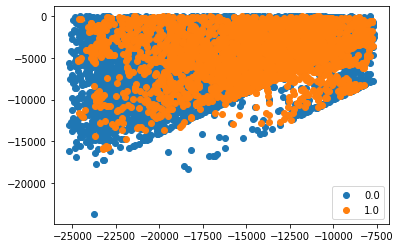

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
Train results:  
Model:  DecisionTreeClassifier() 
Best parameters:  {} 
Best ROC AUC: 0.86
Test results: 
Cost (10fn+fp): 0.74
AUC: 0.53
Accuracy: 0.84


In [21]:
# Second option : borderline-SMOTE with SVM for imbalanced dataset

%pylab inline
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SVMSMOTE()
X_, y_ = oversample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y_ == label)[0]
 pyplot.scatter(X_[row_ix, 0], X_[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

# Fitting model
clf = GridSearchCV(model,param_grid={},cv=5,scoring='roc_auc',verbose=2)
clf.fit(X_,y_)
y_pred = clf.predict(X_test)

# Train scoring
print('Train results: ','\nModel: ', clf.best_estimator_, '\nBest parameters: ', clf.best_params_, '\nBest ROC AUC: %.2f' % clf.best_score_)
y_pred = clf.predict(X_test)
#fpr, fnr, thresholds = det_curve(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()

# Test scoring
print('Test results: ')
print('Cost (10fn+fp): {:.2f}'.format(10*fn+fp))
#print('Cost (10fnr+fpr): {:.2f}'.format(10*fnr[1]+fpr[1]))
print('AUC: %.2f' % roc_auc_score(y_test, y_pred))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

We choose BorderlineSMOTE() over borderline-SMOTE with SVM. the first Borderline has a better scores with the baseline model DecisionTreeClassifier

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Counter({0.0: 7347, 1.0: 653})
Counter({0.0: 7347, 1.0: 7347})


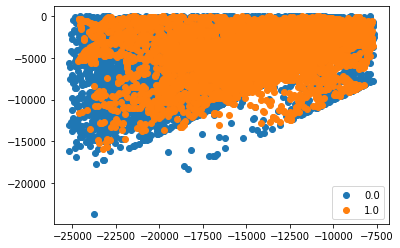

In [22]:
# borderline-SMOTE for imbalanced dataset (data are already normalized)
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE

%pylab inline
# summarize class distribution
counter = Counter(y_train)
print(counter)
# transform the dataset
oversample = BorderlineSMOTE()
X_, y_ = oversample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(y_ == label)[0]
 pyplot.scatter(X_[row_ix, 0], X_[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

## 3-2 : Model testing

In [23]:
import time

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, precision_recall_fscore_support


In [24]:
# Custom score function
from sklearn.metrics import make_scorer, det_curve

def cost_function(y_test, y_pred):
    fpr, fnr, thresholds = det_curve(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    return 10*fn + fp

custom_scorer = make_scorer(cost_function, greater_is_better=False)

In [25]:
# Confusion matrix function
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confmat(y_test, y_pred):

    conf_matrix = confusion_matrix(y_test, y_pred, normalize='all')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    print('fp : ',fp,'\ntn : ', fn)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)

    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format   
    # annot = True: show the numbers in each heatmap cell
    # fmt = 'd': show numbers as integers. 
    ax = sns.heatmap(conf_matrix, annot=True, fmt='.2g')

    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['0', '1'])

    # set y-axis label and ticks
    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['0', '1'])

    # set plot title
    ax.set_title("Confusion Matrix for credit default", fontsize=14, pad=20)

    plt.show()

In [26]:
# Definition of the models to train and test

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randint

# Instanciation des différents modèles

LOGREG_clf = LogisticRegression() 
RFC_clf= RandomForestClassifier()
DUMMY_clf = DummyClassifier()
LGBM_clf=LGBMClassifier()

# Estimators list

estimators = [("DummyClassifier", DUMMY_clf),    
              ("LightGBM",LGBM_clf), 
              ("RandomForestClassifier", RFC_clf),               
              ("LogisticRegression", LOGREG_clf)                
             ]

# Hyperparameters range for the estimators 

LOGREG_rand_params= [{'max_iter':sp_randint(500, 5000),
                      'C': np.logspace(-4, 4, 20),
                     }]
    
RFC_rand_params= [{'n_estimators' :[100,500],
                   'max_depth':[3,5,None],
                   'max_features':sp_randint(1,3),
                   'criterion':['gini'], 
                   'bootstrap':[True,False],
                   'min_samples_leaf':sp_randint(1,4)                   
                  }]

LGBM_rand_params=[{'nthread':[2,6],
                   'n_estimators':[300,700,1000],
                   'learning_rate':sp_randFloat(0.02,0.2),
                   'num_leaves':[30,35],
                   'max_depth':[5,10,15],
                   'min_child_weight':[35,40],
                  }]
            
Dummy_rand_params= [{'strategy':['stratified']
                    }]      

# Hyperparameters dictionary used for RandomizedSearchCV

params_list_RndSearchCV =  {'DummyClassifier': Dummy_rand_params,
                            'LightGBM':LGBM_rand_params,
                            'RandomForestClassifier': RFC_rand_params,
                            'LogisticRegression': LOGREG_rand_params
                           } 

## 3-3 : Scoring

model :  DummyClassifier(strategy='stratified')
fp :  0.458 
tn :  0.032


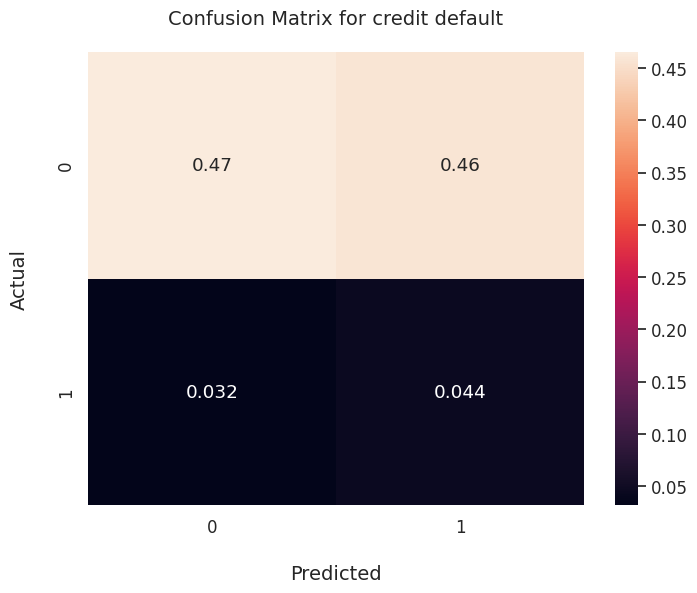

              precision    recall  f1-score   support

         0.0       0.94      0.50      0.66      1847
         1.0       0.09      0.58      0.15       153

    accuracy                           0.51      2000
   macro avg       0.51      0.54      0.40      2000
weighted avg       0.87      0.51      0.62      2000

custom score train :  2.77
custom score test :  0.778
###################################################################################
[LightGBM] [Warning] num_threads is set with nthread=6, will be overridden by n_jobs=-1. Current value: num_threads=-1
model :  LGBMClassifier(learning_rate=0.14237057894447588, max_depth=10,
               min_child_weight=40, n_estimators=1000, nthread=6,
               num_leaves=35)
fp :  0.0105 
tn :  0.071


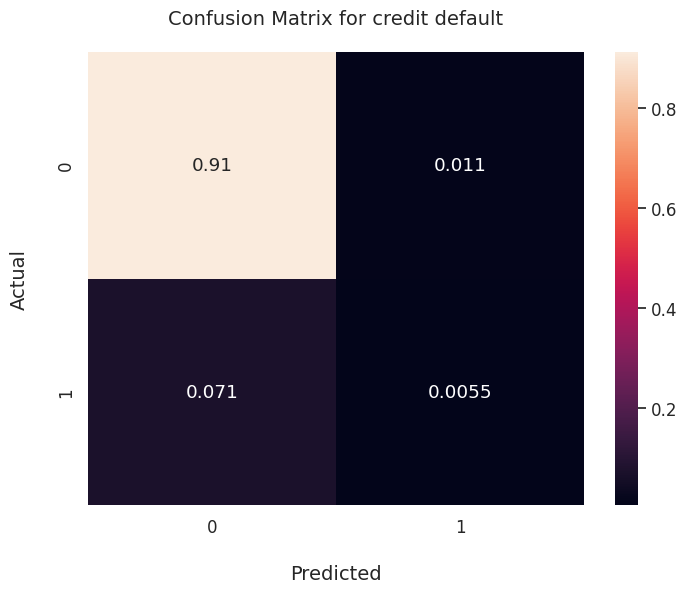

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1847
         1.0       0.34      0.07      0.12       153

    accuracy                           0.92      2000
   macro avg       0.64      0.53      0.54      2000
weighted avg       0.88      0.92      0.89      2000

custom score train :  0.42
custom score test :  0.7204999999999999
###################################################################################


In [27]:
# Train/fit models and display best model evaluations, graphs and scores
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score

result_table = []

for (name, est) in (estimators):
    # Cross validation with RandomizedSearchCV

    score = df.shape[0]
    model=[]
    Names=[]
    
    # paramètre CV
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)    # n_splits=10, n_repeats=3
    
    # Instance RandomizedSearchCV
    clf = RandomizedSearchCV(est, 
                                param_distributions=params_list_RndSearchCV[name],
                                n_iter=10, 
                                cv=cv, 
                                scoring=custom_scorer, 
                                n_jobs=-1,    
                                random_state=42,
                                refit="custom_scorer"
                                )  

    # Fit
    clf.fit(X_, y_)

    # Predict
    y_pred = clf.best_estimator_.predict(X_test)

    # Display results
    print("model : ", clf.best_estimator_)
    confmat(y_test, y_pred)
    print(classification_report (y_test, y_pred))
    print("custom score train : ",(-clf.best_score_).round(2))
    print("custom score test : ",cost_function(y_test, y_pred))
    print('###################################################################################')
        
    fpr, tpr, threshold = det_curve(y_test, y_pred)
    result_table.append({'models':clf.best_estimator_, 
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':roc_auc_score(y_test, y_pred),
                                        'F1':f1_score(y_test, y_pred), 
                                        'Custom Cost train':(-clf.best_score_).round(2),
                                        'Custom Cost test' :cost_function(y_test, y_pred),
                                        'Accuracy':accuracy_score(y_test, y_pred)})

In [ ]:
result_table = pd.DataFrame(result_table)
result_table

In [ ]:
# Enregistrement du meilleur modèle (score maison mini)
index = np.argmin(result_table['Custom Cost test'])   
       
Model_name = result_table.iloc[index, 0]
Model_name

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

#fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))
fig, ax_roc = plt.subplots(1, 1, figsize=(10, 10))

for clf in result_table.iloc[:,0]:
    clf.fit(X_, y_)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=clf)
    #DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=clf)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
#ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
#ax_det.grid(linestyle="--")

plt.legend(bbox_to_anchor=(1,1.02))
plt.show()

In [ ]:
# Best Threshold and cost with best model
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
model = Model_name
# entraînez votre modèle de classification binaire
model.fit(X_, y_)

# obtenez les scores de probabilité pour votre ensemble de données de validation ou de test
y_scores = model.predict_proba(X_test)[:, 1]
range_th = np.linspace(0, 1, 101)
range_co = []
# appliquez différents seuils de classification aux scores de probabilité
for threshold in range_th:
    y_pred = (y_scores >= threshold).astype(int)

    # évaluez la performance de chaque prédiction binaire en utilisant des mesures d'évaluation
    range_co.append(cost_function(y_test, y_pred))
    best_th = range_th[argmin(range_co)]
print('Best model : ', model,'\nBest Cost on test sample): ', min(range_co),'\nBest Threshold : ',range_th[argmin(range_co)])

## 3-4 : Feature importance

In [ ]:
# La liste des variables hors target
feature_names = df.columns.tolist()
feature_names.remove('TARGET')

In [ ]:
# Le meilleur modèle entraîné
Best_clf = Model_name
Best_clf.fit(X_, y_)

## RandomForestClassifier

In [ ]:
# La visualisation des important feature pour RandomForest
if str(Model_name).startswith('RandomForest') == True :
    feature_importance = Best_clf.coef_
    sorted_idx = np.argsort(feature_importance) # np.argsort(feature_importance)[-6:-1]
    sorted_idx = sorted_idx[:10]
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(df.columns)[sorted_idx])
    plt.title('Feature Importance')

    # La liste des features importantes
    imp_feat = df_imp_best['Feature'].unique()
    imp_feat

### LogisticRegression

In [ ]:
# La visualisation des important feature pour une régression logistique
if str(Model_name).startswith('Logistic') == True :
    feature_importance = abs(Best_clf.coef_[0])
    sorted_idx = np.argsort(feature_importance) # np.argsort(feature_importance)[-6:-1]
    sorted_idx = sorted_idx[:10]
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(df.columns)[sorted_idx])
    plt.title('Feature Importance')

    # Le dictionnaire des features importance du plus petit au plus grand
    dic_imp = dict(zip(np.array(df.columns)[sorted_idx],feature_importance[sorted_idx]))
    df_imp_best = pd.DataFrame(list(dic_imp.items()), columns = ['Feature', 'Value'])

### LGBMClassifier

In [ ]:
if str(Model_name).startswith('LGBM') :
    import lightgbm

    from lightgbm import LGBMClassifier

    lgbm_model = LGBMClassifier()

    lgbm_model.fit(X_, y_)

    y_pred = lgbm_model.predict(X_test)


    # Vizualisation
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

    def plotImp(model, X , num = 20, fig_size = (40, 20)):
        feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_names})
        plt.figure(figsize=fig_size)
        sns.set(font_scale = 5)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                            ascending=False)[0:num])
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances-01.png')
        plt.show()

    plotImp(lgbm_model,X_,num = 10, fig_size = (40, 20))

    # Le dictionnaire des features importance du plus petit au plus grand
    feature_imp = pd.DataFrame({'Value':lgbm_model.feature_importances_,'Feature':feature_names})
    df_imp_best = feature_imp.sort_values(by="Value",ascending=False)[0:10]

### Réentraînement du meilleur modèle sur les 10 features les plus importantes

In [ ]:
# La liste des features importantes
imp_feat = df_imp_best['Feature'].unique()
imp_feat

In [ ]:
df_ = pd.read_csv('df.csv')[0:2000]

In [ ]:
# Le dataset réduit aux features importantes
feat = imp_feat.tolist()+['TARGET']
df_i = df_.loc[:,feat]
X_i = df_i.drop(columns = 'TARGET').values
y_i = df_i['TARGET'].values

In [ ]:
# Split du dataset
X_tr, X_te, y_tr, y_te = train_test_split(X_i,y_i,test_size=0.2, random_state=42)

In [ ]:
# Entraînement du modéle
Model_name.fit(X_tr, y_tr)

In [ ]:
# Vérification du score
y_te_pred = Model_name.predict(X_te)
y_te_pred = (y_te_pred >= best_th)
tn, fp, fn, tp = confusion_matrix(y_te, y_te_pred, normalize='all').ravel()

# Test scoring
print('Test results: ')
print('Cost (10fn+fp): {:.2f}'.format(10*fn+fp))
print('AUC: %.2f' % roc_auc_score(y_test, y_pred))
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Part 4 : Recording model and experiment

In [ ]:
# Recording model with pickle
import pickle
pickle.dump(Model_name,open("Best_predictor.pkl","wb"))

In [ ]:
# Recording experiment
import os

record_dir = "./rd"
os.makedirs(record_dir, exist_ok=True)

In [ ]:
%%writefile {record_dir}/main.py
import os
import argparse
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
#from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

def main():

    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    ###################
    #<prepare the data>
    ###################
        
    scaler = RobustScaler()

    df = pd.read_csv('df.csv')
    X = df.drop(columns='TARGET').values
    X = scaler.fit_transform(X)
    y = df['TARGET'].values
    
    registered_model_name = 'LGBM'
       
    #LGBM_clf = LGBMClassifier(learning_rate=0.0330103185970559, max_depth=5,
    #           min_child_weight=40, n_estimators=700, nthread=6, num_leaves=35)
    
    LGBM_clf = LogisticRegression(C=0.00026366508987303583, max_iter=2891)
    LGBM_clf.fit(X,y)

    mlflow.log_metric("num_samples", df.shape[0])
    mlflow.log_metric("num_features", df.shape[1] - 1)

    ##########################
    #<save and register model with mlflow>
    ##########################
    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=LGBM_clf,
        registered_model_name=registered_model_name,#args.registered_model_name,
        artifact_path=registered_model_name#args.registered_model_name,
    )

    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=LGBM_clf,
        path=os.path.join(registered_model_name, "trained_model_PDS7_lgbm"),
    )
    ###########################
    #</save and register model>
    ###########################
    
   

    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()

In [ ]:
from azure.ai.ml import command
from azure.ai.ml import Input

registered_model_name = "credit_defaults_model_PDS7"

job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="df.csv" #"https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
        ),
        #test_train_ratio=0.2,
        #learning_rate=0.25,
        registered_model_name=registered_model_name,
    ),
    code="./rd/",  # location of source code
    command="python main.py --data ${{inputs.data}} --registered_model_name ${{inputs.registered_model_name}}",
    environment="aml-scikit-learn@latest",
    compute="PDS6",
    experiment_name="train_model_credit_default_prediction_PDS7",
    display_name="credit_default_prediction_PDS7",
)

In [ ]:
ml_client.create_or_update(job)

# Part 5 : Deploying model

In [ ]:
See other